In [1]:
import os
from PIL import Image

def load_dataset(dataset_path):
    images = []
    labels = []
    
    # Get class names and clean them
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    classes = [name.replace('_dataset', '') for name in classes]  # Remove '_dataset' from names
    
    # Create class to index mapping
    class_to_idx = {name + '_dataset' if 'dataset' in orig_name else name: idx 
                   for idx, (name, orig_name) in enumerate(zip(classes, sorted([d for d in os.listdir(dataset_path) 
                   if os.path.isdir(os.path.join(dataset_path, d))])))}
    
    # Load images and labels
    for orig_class in os.listdir(dataset_path):
        if os.path.isdir(os.path.join(dataset_path, orig_class)):
            class_path = os.path.join(dataset_path, orig_class)
            class_idx = class_to_idx[orig_class]
            
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    img = Image.open(img_path).convert('RGB')
                    images.append(img)
                    labels.append(class_idx)
    
    return images, labels, classes

dataset_path = "NDD_DATASET"
images, labels, classes = load_dataset(dataset_path)
print(f"Number of images loaded: {len(images)}")
print(f"Classes found: {classes}")

Number of images loaded: 7590
Classes found: ['alzheimers', 'normal', 'parkinsons']


In [2]:
def resize_images_to_minimally_divisible_by_8(images):
    resized_images = []
    for img in images:
        # Get original dimensions
        width, height = img.size
        
        # Calculate the new dimensions by reducing minimally to make them divisible by 8
        new_width = width - (width % 8)
        new_height = height - (height % 8)
        
        # Check if resizing is needed
        if width != new_width or height != new_height:
            print(f"Original size: {width}x{height} -> New size: {new_width}x{new_height}")
        
        # Crop the image to the new dimensions
        resized_img = img.crop((0, 0, new_width, new_height))
        resized_images.append(resized_img)
    
    return resized_images

# Resize all images to make their dimensions divisible by 8 and log changes
resized_images = resize_images_to_minimally_divisible_by_8(images)

# Check that all images are now divisible by 8
for idx, img in enumerate(resized_images):
    width, height = img.size
    assert width % 8 == 0 and height % 8 == 0, f"Image at index {idx} is not divisible by 8!"

print("All images resized to dimensions minimally divisible by 8.")


Original size: 250x320 -> New size: 248x320
Original size: 364x448 -> New size: 360x448
Original size: 364x448 -> New size: 360x448
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 364x448 -> New size: 360x448
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 260x320 -> New size: 256x320
Original size: 250x320 -> New size: 248x320
Original size: 260x320 -> New size: 256x320
Original size: 260x320 -> New size: 256x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 364x448 -> New si

In [3]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define your transforms here
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Split data into train, validation, and test sets (80:10:10)
train_images, test_images, train_labels, test_labels = train_test_split(
    resized_images, labels, test_size=0.2, random_state=43, stratify=labels
)

val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=43, stratify=test_labels
)

# Create datasets for each split
train_dataset = CustomImageDataset(images=train_images, labels=train_labels, transform=transform)
val_dataset = CustomImageDataset(images=val_images, labels=val_labels, transform=transform)
test_dataset = CustomImageDataset(images=test_images, labels=test_labels, transform=transform)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Checking DataLoader
for images, labels in train_loader:
    print(images.shape)  # Should print batch size and dimensions
    break


torch.Size([16, 3, 224, 224])


In [4]:
from transformers import ViTForImageClassification, ViTConfig

# Set patch size to 8x8
config = ViTConfig(
    image_size=224,   # Image size (224x224 is commonly used)
    patch_size=8,     # Set patch size to 8x8
    num_labels=3,    # Number of output classes (adjust according to your dataset)
)

# Initialize the model with the new configuration
model = ViTForImageClassification(config)

Epoch 1/50
Train Loss: 0.6531, Train Accuracy: 0.6683
Validation Loss: 0.5262, Validation Accuracy: 0.6403
Validation loss improved. Model saved.
Epoch 2/50
Train Loss: 0.5249, Train Accuracy: 0.7302
Validation Loss: 0.7995, Validation Accuracy: 0.6232
No improvement in validation loss. Early stopping counter: 1/5
Epoch 3/50
Train Loss: 0.4783, Train Accuracy: 0.7561
Validation Loss: 0.4382, Validation Accuracy: 0.7760
Validation loss improved. Model saved.
Epoch 4/50
Train Loss: 0.4530, Train Accuracy: 0.7638
Validation Loss: 0.4619, Validation Accuracy: 0.7879
No improvement in validation loss. Early stopping counter: 1/5
Epoch 5/50
Train Loss: 0.4148, Train Accuracy: 0.7973
Validation Loss: 0.3745, Validation Accuracy: 0.8314
Validation loss improved. Model saved.
Epoch 6/50
Train Loss: 0.3705, Train Accuracy: 0.8279
Validation Loss: 0.4841, Validation Accuracy: 0.7510
No improvement in validation loss. Early stopping counter: 1/5
Epoch 7/50
Train Loss: 0.3550, Train Accuracy: 0.834

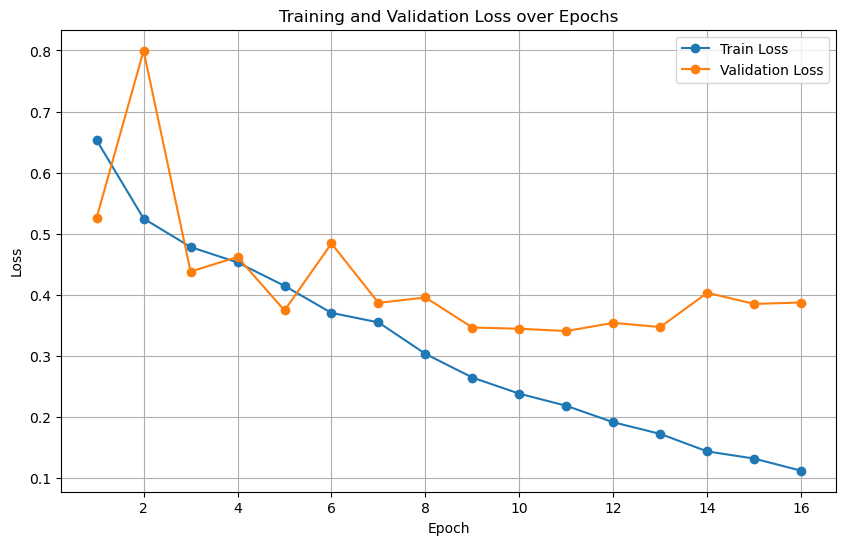

In [6]:
import torch
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)
    
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / total_preds
    return epoch_loss, epoch_accuracy

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            
            # Calculate loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)
    
    eval_loss = running_loss / len(dataloader)
    eval_accuracy = correct_preds / total_preds
    return eval_loss, eval_accuracy

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping
best_val_loss = float('inf')  # Initialize best validation loss to infinity
counter = 0  # Counter for early stopping

# Initialize lists to store losses for each epoch
train_losses = []
val_losses = []

# Training loop with loss tracking and early stopping
num_epochs = 50  # Set a high number of epochs to test early stopping
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
    # Validation
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation loss improved. Model saved.")
    else:
        counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {counter}/{patience}")
        
        if counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Updated testing function
def test_with_metrics(model, dataloader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images).logits
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, report, cm

# Test the model
class_names = classes  
test_accuracy, classification_report_str, confusion_matrix_arr = test_with_metrics(model, test_loader, device, class_names)

# Print metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report_str)
print("\nConfusion Matrix:\n", confusion_matrix_arr)


Test Accuracy: 0.8827

Classification Report:
               precision    recall  f1-score   support

  alzheimers       0.82      0.86      0.84       250
      normal       0.86      0.81      0.83       270
  parkinsons       0.98      0.98      0.98       239

    accuracy                           0.88       759
   macro avg       0.88      0.89      0.89       759
weighted avg       0.88      0.88      0.88       759


Confusion Matrix:
 [[216  33   1]
 [ 46 219   5]
 [  0   4 235]]
